# Model Shapping

In [1]:
# Importing the libraries
import os
import pandas as pd
import numpy as np

## Load data

In [2]:
# Load and preprocess the train data 
from pipelines import pipeline

data_file = os.path.join('..', '..', '..', '..', 'data', 'raw', 'train.csv')
train_data = pd.read_csv(data_file, index_col=0, low_memory=False)
train_data = pipeline.fit_transform(train_data)

X = train_data.drop(columns=['bg+1:00'])
y = train_data['bg+1:00']

## Train model with the whole dataset

In [3]:
from src.features.tuners import BaggingHyperparameterTuner
from sklearn.metrics import root_mean_squared_error

tuner = BaggingHyperparameterTuner()
model = tuner.regressor()
model.fit(X=X, y=y)

root_mean_squared_error(y_true=y, y_pred=model.predict(X=X))

np.float64(0.716030463211452)

## Feature importances

In [4]:
# Extract and average feature importances from each decision tree in the ensemble
feature_importances = np.mean([tree.feature_importances_ for tree in model.estimators_], axis=0)
top_feature_importances = pd.Series(feature_importances, index=X.columns).sort_values(ascending=False)
top_feature_importances

bg-0:00                   0.508518
bg-0:15                   0.028079
insulin-0:15              0.015662
bg-0:30                   0.015080
insulin-0:30              0.014713
insulin-0:45              0.012999
bg-5:45                   0.012781
bg-0:45                   0.011184
insulin-0:00              0.010959
insulin-1:00              0.010946
bg-1:00                   0.010824
bg-1:15                   0.010524
insulin-5:45              0.010347
insulin-1:15              0.010156
bg-1:30                   0.009943
insulin-1:30              0.009860
insulin-2:00              0.009794
bg-1:45                   0.009683
bg-5:30                   0.009374
insulin-2:15              0.009365
bg-2:15                   0.009351
insulin-4:45              0.009305
insulin-1:45              0.009282
insulin-4:00              0.009135
insulin-5:15              0.009113
bg-5:00                   0.009049
bg-2:30                   0.009048
insulin-2:45              0.009047
insulin-2:30        

In [5]:
from joblib import Parallel, delayed
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm
import numpy as np

rmse_on_feature_length = {}
for i in tqdm(range(len(top_feature_importances), 0, -1)):
    X_new = X[top_feature_importances.index[:i]]
    model = tuner.regressor()
    kf = KFold(n_splits=5, shuffle=True, random_state=42)


    def train(train_index, test_index):
        X_train, X_test = X_new.iloc[train_index], X_new.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        return root_mean_squared_error(y_test, y_pred)


    out = Parallel(n_jobs=5, pre_dispatch='1.5*n_jobs', timeout=600)(delayed(train)(train_index, test_index) for train_index, test_index in kf.split(X_new, y))
    rmse_on_feature_length[i] = np.mean(out)

  0%|          | 0/53 [00:00<?, ?it/s]

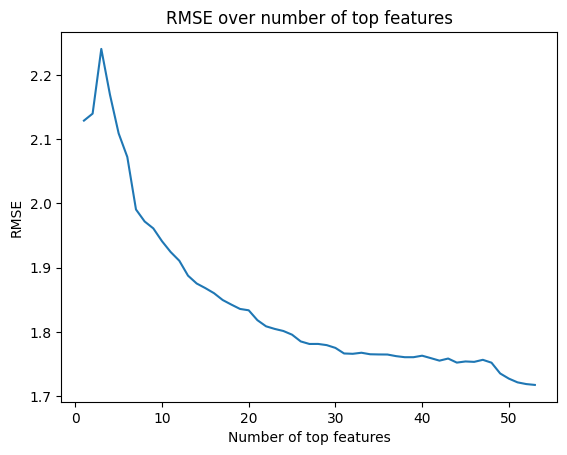

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(list(rmse_on_feature_length.keys()), list(rmse_on_feature_length.values()))
plt.title('RMSE over number of top features')
plt.xlabel('Number of top features')
plt.ylabel('RMSE')
plt.show()

In [7]:
# Find the key with the minimum value
min_key = min(rmse_on_feature_length, key=rmse_on_feature_length.get)

print("Index with the minimum value:", min_key)
print("Minimum value:", rmse_on_feature_length[min_key])

Index with the minimum value: 53
Minimum value: 1.7176946060787024
